In [1]:
import numpy as np
import MultiPoint.WLCgreen as wlc
import MultiPoint.propagator as propagator
import matplotlib.pyplot as plt
%matplotlib
from numba import jit

Using matplotlib backend: Qt5Agg


In [2]:
def plotlog(x, y, alpha, xrange=1, numx=2):
    xv = np.logspace(np.log10(x), np.log10(x) + xrange, numx)
    C = y / (x**alpha)
    yv = C * xv**(alpha)
    plt.loglog(xv, yv,'k--')

# Eigenvalues

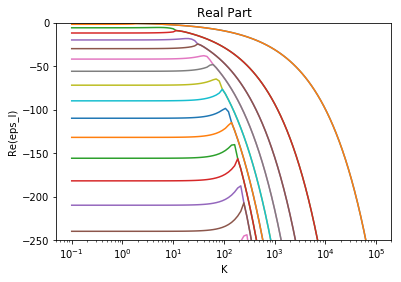

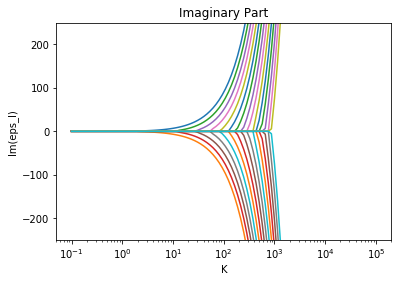

In [3]:
npts=100
Kvals=np.logspace(-1,5,npts)
ORDEig=30
allEvals=np.zeros((npts,ORDEig),dtype='complex')
mu=0
for ii in range(0,npts):
    allEvals[ii,:]= wlc.wlc_eigvals(Kvals[ii],ORDEig,mu)  
plt.figure()    
for ii in range(mu,ORDEig):
    plt.semilogx(Kvals,np.real(allEvals[:,ii]))
plt.ylim([-250,0])
plt.title('Real Part')
plt.ylabel('Re(eps_l)')
plt.xlabel('K')
plt.show()

plt.figure() 
for ii in range(mu,ORDEig):
    plt.semilogx(Kvals,np.imag(allEvals[:,ii]))
plt.ylim([-250,250])
plt.title('Imaginary Part')
plt.ylabel('Im(eps_l)')
plt.xlabel('K')
plt.show()  

# Residue

In [4]:
ORDEig=100

npts=100
npoles=5
resPlot=np.zeros((npts,npoles),dtype='complex')
resSmallPlot=np.zeros((npts,npoles),dtype='complex')
resSwitch=np.zeros((npts,npoles),dtype='complex')
Ks=np.logspace(-4,4,npts)
for ii in range(0,npts):
    K=Ks[ii]
    lam0=0
    lam=0
    mu=0
    eigvals = wlc.wlc_eigvals(K,ORDEig,mu,d=3)
    for l in range(mu,npoles):
        eig=eigvals[l]
        res, resSmall = wlc.bothResidues(K,eig,l,mu,nlam=10,d=3)
        resPlot[ii,l]=res[lam0,lam]
        resSmallPlot[ii,l]=resSmall[lam0,lam]
        resSwitch[ii,l]=wlc.residues(K,eig,l,mu,nlam=10,d=3)[lam0,lam]
    


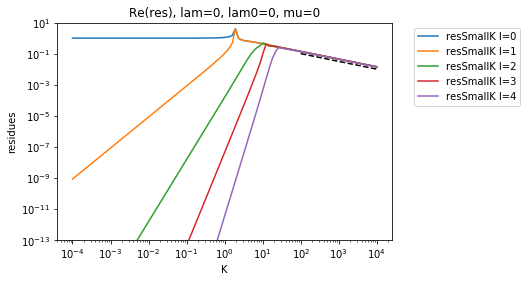

In [5]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.real,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.real,'b',label='resSmallK')
for l in range(mu,npoles):
    #ax.loglog(Ks,abs(resPlot[:,l].real),'r',label='res '+str(l))  
    #ax.loglog(Ks,Ks**0.0*abs(resSmallPlot[:,l].real),'c',label='resSmallK '+str(l))
    ax.loglog(Ks,abs(resSwitch[:,l]),'-',label='resSmallK l='+str(l))

#ax.legend(loc=4)
ax.set_ylim([0.0000000000001,10])
ax.set_title('Re(res), lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_xlabel('K')
ax.set_ylabel('residues')
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
plotlog(1e2, 1e-1, -0.5, xrange=2)
plt.show()



/home/users/qmac/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


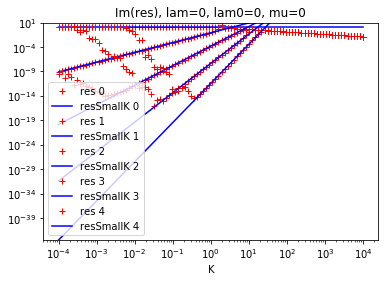

In [6]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for l in range(mu,npoles):
    ax.loglog(Ks,abs(resPlot[:,l]),'r+',label='res '+str(l))  
    ax.loglog(Ks,abs(resSmallPlot[:,l]),'b',label='resSmallK '+str(l))
ax.set_xlabel('K')
ax.legend(loc=3)
ax.set_title('Im(res), lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_ylim([-10,10])
plt.show()

/home/users/qmac/.anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


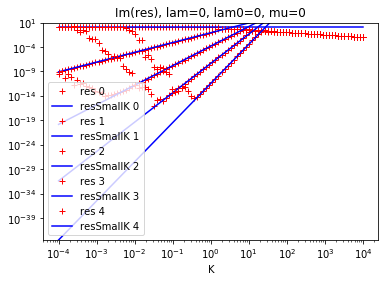

In [7]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for l in range(mu,npoles):
    ax.loglog(Ks,abs(resPlot[:,l].real),'r+',label='res '+str(l))  
    ax.loglog(Ks,abs(resSmallPlot[:,l].real),'b',label='resSmallK '+str(l))
ax.set_xlabel('K')
ax.legend(loc=3)
ax.set_title('Im(res), lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_ylim([-10,10])
plt.show()

# Inverse Laplace Tools

## G0 and dG0

In [8]:
ORDEig=100
lamMax=500
npts=100
npoles=5
d=3
resPlot=np.zeros((npts,npoles),dtype='complex')
resSmallPlot=np.zeros((npts,npoles),dtype='complex')
resSwitch=np.zeros((npts,npoles),dtype='complex')
Ks=np.logspace(-4,4,npts)

Wout=np.zeros(npts,dtype='complex')
dWout=np.zeros(npts,dtype='complex')
G0out=np.zeros(npts,dtype='complex')
dG0out=np.zeros(npts,dtype='complex')
djpout=np.zeros(npts,dtype='complex')
djmout=np.zeros(npts,dtype='complex')
jpout=np.zeros(npts,dtype='complex')
jmout=np.zeros(npts,dtype='complex')
for ii in range(0,npts):
    K=Ks[ii]
    lam0=2
    lam=3
    mu=0
    
    jp=wlc.get_jp(0.0,mu,K,lamMax,d)
    jm= wlc.get_jm_zero(mu,K,lamMax,d)

    djp=wlc.get_djp(0.0,mu,K,lamMax,jp,d)
    djm=wlc.get_djm_zero(mu,K,lamMax,jm,d)


    dwm=wlc.get_dwm_zero(jm,djm,K,lamMax,mu,d)
    dwp=-djp/(jp**2) # This line prevents jit ???

    W=wlc.get_W_zero(mu,K,lamMax,jp,jm,d)
    dW=wlc.get_dW_zero(mu,K,lamMax,dwp,dwm,W,d)
    
    dWout[ii]=dW[lam0]
    Wout[ii]=W[lam0]
    djpout[ii]=djp[lam0]
    djmout[ii]=djm[lam0]
    jpout[ii]=jp[lam0]
    jmout[ii]=jm[lam0]

    G0out[ii]=wlc.get_G_zero(lam,lam0,mu,K,jm,jp,W,d)
    dG0out[ii] =wlc.get_dG_zero(lam,lam0,mu,K,jm,jp,W,dW,dwm,dwp,d)
           

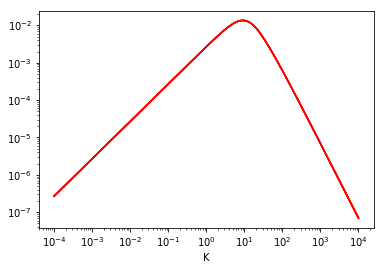

In [9]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for l in range(mu,npoles):
    #ax.loglog(Ks,abs(G0out),'b')  
    ax.loglog(Ks,abs(dG0out),'r')
ax.set_xlabel('K')
plt.show()

## Laurent R, a, and b

In [10]:
nlam=5
ORDEig=10
d=3
mu=0

nkpts=200
Ks=np.logspace(-4,7,nkpts)
props1=[] # list of propagators at each K
props2=[] # list of propagators at each K
for ii in range(0,nkpts):

    name=ii
    props1.append( propagator.propagator(name,Ks[ii],mu,nlam=nlam) )

In [11]:
npoles=5
lam=0
lam0=0
resPlot=np.zeros((nkpts,npoles),dtype=type(1+1j))
aPlot=np.zeros((nkpts,npoles),dtype=type(1+1j))
bPlot=np.zeros((nkpts,npoles),dtype=type(1+1j))
for ii in range(0,nkpts):
    for l in range(0,npoles):
        resPlot[ii,l]=props1[ii].res[l][lam0,lam]
        aPlot[ii,l]=props1[ii].a[l][lam0,lam]
        bPlot[ii,l]=props1[ii].b[l][lam0,lam]

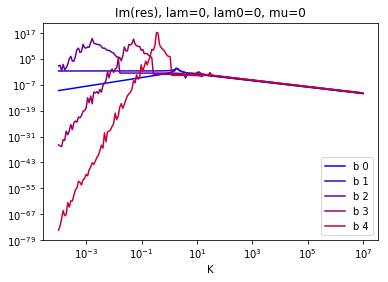

In [12]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for l in range(mu,npoles):
    col=float(l)/npoles
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.loglog(Ks,abs(bPlot[:,l]),color=[col, 0.0, 1-col],label='b '+str(l))
ax.set_xlabel('K')
ax.legend(loc=4)
ax.set_title('Im(res), lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
#ax.set_ylim([-10,10])
plt.show()

## G(K,p), W and w

In [13]:
npval=10
p=np.logspace(-1,2,npval)
nlam=5
ORDEig=10
d=3
mu=1
lam0=2
lam=1

nkpts=200
Ks=np.logspace(-4,7,nkpts)
out=np.zeros((nkpts,npval),dtype='complex')
for ii in range(0,nkpts):
    for jj in range(0,npval):
        G, W, wp, wm = wlc.CalcG(Ks[ii],p[jj],mu,nlam=10,d=3,lamMax=500)
        out[ii,jj]=G[lam0,lam]

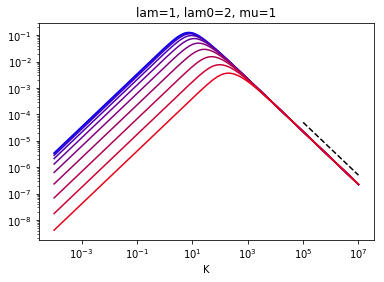

In [14]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for jj in range(0,npval):
    col=float(jj)/npval
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.loglog(Ks,abs(out[:,jj]),color=[col, 0.0, 1-col],label='p='+str(p[jj]))
ax.set_xlabel('K')
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
plotlog(1e5, 5e-5, -1, xrange=2)
#ax.set_ylim([-10,10])
plt.show()

## lim p->0 of G(K,p) and dG(k,p)

Direct Calculation of G(p)

In [15]:
npval=100
p=-np.logspace(-7,-1,npval)
nlam=5
ORDEig=10
d=3
mu=2
lam0=2
lam=2

nkpts=11
Ks=np.logspace(-2,7,nkpts)
Gofp=np.zeros((nkpts,npval),dtype='complex')
for ii in range(0,nkpts):
    for jj in range(0,npval):
        G, W, wp, wm = wlc.CalcG(Ks[ii],p[jj],mu,nlam=10,d=3,lamMax=500)
        Gofp[ii,jj]=G[lam0,lam]

In [16]:
dGofp=np.zeros((nkpts,npval-1),dtype='complex')
for ii in range(0,nkpts):
    dGofp[ii,:]=(Gofp[ii,1:]-Gofp[ii,0:-1])/(p[1:]-p[0:-1])
p2=0.5*(p[1:]+p[0:-1])

G(p) in limit p->0

In [17]:
lamMax=500
G0=np.zeros((nkpts),dtype='complex')
dG0=np.zeros((nkpts),dtype='complex')
for ii in range(0,nkpts):
    K=Ks[ii]
    jp=wlc.get_jp(0.0,mu,K,lamMax,d)
    jm= wlc.get_jm_zero(mu,K,lamMax,d)

    djp=wlc.get_djp(0.0,mu,K,lamMax,jp,d)
    djm=wlc.get_djm_zero(mu,K,lamMax,jm,d)


    dwm=wlc.get_dwm_zero(jm,djm,K,lamMax,mu,d)
    dwp=-djp/(jp**2) # This line prevents jit ???

    W=wlc.get_W_zero(mu,K,lamMax,jp,jm,d)
    dW=wlc.get_dW_zero(mu,K,lamMax,dwp,dwm,W,d)


    G0[ii]=wlc.get_G_zero(lam,lam0,mu,K,jm,jp,W,d)
    dG0[ii]=wlc.get_dG_zero(lam,lam0,mu,K,jm,jp,W,dW,dwm,dwp,d)


In [18]:
G0

array([1.66666634e-01+0.j, 1.66664580e-01+0.j, 1.66535163e-01+0.j,
       1.58900676e-01+0.j, 6.21040664e-02+0.j, 9.11516471e-03+0.j,
       1.16935559e-03+0.j, 1.47561593e-04+0.j, 1.85824315e-05+0.j,
       2.33947714e-06+0.j, 2.94655502e-07+0.j])

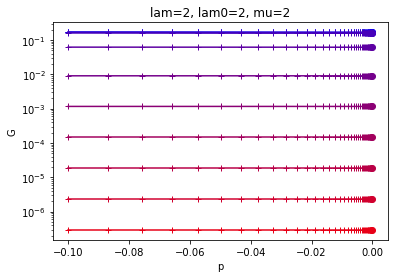

In [19]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for ii in range(0,nkpts):
    col=float(ii)/nkpts
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.semilogy(p,abs(Gofp[ii,:]),'+-',color=[col, 0.0, 1-col],label='K='+str(Ks[ii]))
    ax.semilogy(0.0,abs(G0[ii]),'o',color=[col, 0.0, 1-col])
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_ylabel('G')
ax.set_xlabel('p')
plt.show()

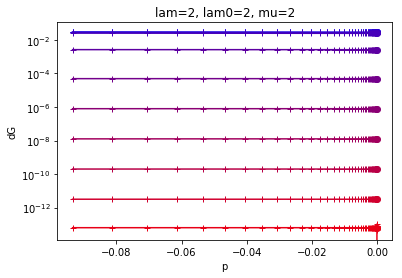

In [20]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for ii in range(0,nkpts):
    col=float(ii)/nkpts
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.semilogy(p2,abs(dGofp[ii,:]),'+-',color=[col, 0.0, 1-col],label='K='+str(Ks[ii]))
    ax.semilogy(0.0,abs(dG0[ii]),'o',color=[col, 0.0, 1-col])
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_ylabel('dG')
ax.set_xlabel('p')
plt.show()

# G(K,N)

In [21]:
nlam=5
ORDEig=25
d=3
mu=0

nkpts=2000
Ks=np.logspace(-3,7,nkpts)
props1=[] # list of propagators at each K
props2=[] # list of propagators at each K
for ii in range(0,nkpts):

    name=ii
    props1.append( propagator.propagator(name,Ks[ii],mu,nlam=nlam) )




In [22]:
N=np.array([0.1,1,10,100,1000])
#N=np.array([0.3,1.1,1.9,2.7,3.5])
lam=0
lam0=0
nnvals=len(N)
G=np.zeros((nkpts,nnvals),dtype=type(1+1j))
for ii in range(0,nkpts):
    for nn in range(0,nnvals):
        G[ii,nn] = props1[ii].get_G(N[nn],lam0,lam)

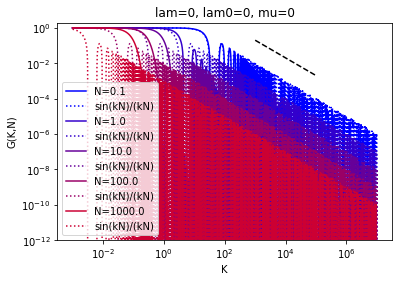

In [23]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for jj in range(0,nnvals):
    col=float(jj)/nnvals
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.loglog(Ks,G[:,jj].real,color=[col, 0.0, 1-col],label='N='+str(N[jj]))
    ax.loglog(Ks,np.sin(Ks*N[jj])/(Ks*N[jj]),':',color=[col, 0.0, 1-col],label='sin(kN)/(kN)')
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_xlabel('K')
ax.set_ylabel('G(K,N)')
ax.legend(loc=3)
plotlog(1e3, 2e-1, -1, xrange=2)
ax.set_ylim([10**-12,2])
plt.show()

# G(R,N)

In [24]:
import scipy.special as special
from scipy.interpolate import splint
from scipy.interpolate import splrep

In [25]:
nrvals=100
r=np.linspace(0,1,nrvals) # R/L or R/L

integral=np.zeros((nrvals,nnvals))
for jj in range(0,nnvals):
    for ii in range(0,nrvals):
        y=Ks**2 * special.spherical_jn(0,Ks*r[ii]*N[jj]) * G[:,jj].real
        tck=splrep(Ks,y,k=1)
        integral[ii,jj] = splint(0,Ks[-1],tck)

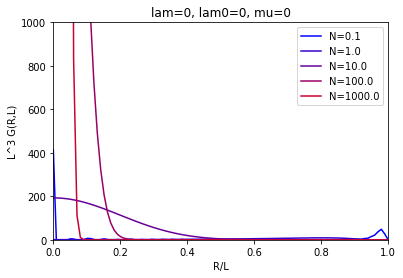

In [26]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for jj in range(0,nnvals):
    col=float(jj)/nnvals
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.plot(r,N[jj]**3*integral[:,jj],color=[col, 0.0, 1-col],label='N='+str(N[jj]))
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_xlabel('R/L')
ax.set_ylabel('L^3 G(R,L)')
ax.legend()
ax.set_xlim([0,1.0])
ax.set_ylim([0,1000])
plt.show()

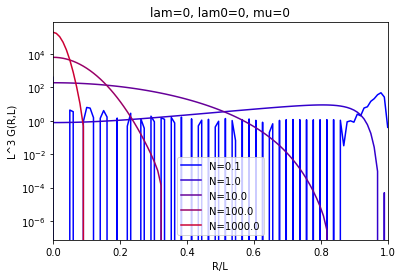

In [27]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for jj in range(0,nnvals):
    col=float(jj)/nnvals
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.semilogy(r,N[jj]**3*integral[:,jj],color=[col, 0.0, 1-col],label='N='+str(N[jj]))
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_xlabel('R/L')
ax.set_ylabel('L^3 G(R,L)')
ax.legend()
ax.set_xlim([0,1.0])
plt.show()

## P(R,N)

$$
P\left(\tilde{r};N\right)=N^{3}\frac{2\tilde{r}^{2}}{\pi}\int dK\cdot K^{2}j_{0}\left(K\tilde{r}N\right)\mathcal{G}_{0,0}^{0}\left(K,N\right)
$$
where $\tilde{r}=\left|\vec{R}\right|/L$.

In [28]:
nrvals=100
r=np.linspace(0,1,nrvals) # R/L or R/L

P=np.zeros((nrvals,nnvals))
for jj in range(0,nnvals):
    for ii in range(0,nrvals):
        y=N[jj]**3*(2*r[ii]**2/np.pi)*Ks**2 * special.spherical_jn(0,Ks*r[ii]*N[jj]) * G[:,jj].real
        tck=splrep(Ks,y,k=1)
        P[ii,jj] = splint(0,Ks[-1],tck)

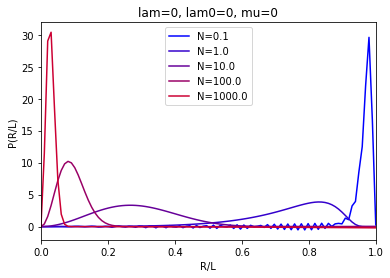

In [29]:
fig, ax = plt.subplots()
#ax.semilogx(Ks,resPlot.imag,'r',label='res')  
#ax.semilogx(Ks,resSmallPlot.imag,'b',label='resSmallK')
for jj in range(0,nnvals):
    col=float(jj)/nnvals
    #ax.loglog(Ks,abs(resPlot[:,l]),color=[col, 0.0, 1-col],label='res '+str(l))  
    #ax.loglog(Ks,abs(aPlot[:,l]),color=[col, 0.0, 1-col],label='a '+str(l))
    ax.plot(r,P[:,jj],color=[col, 0.0, 1-col],label='N='+str(N[jj]))
ax.set_title('lam='+str(lam)+', lam0='+str(lam0)+', mu='+str(mu))
ax.set_xlabel('R/L')
ax.set_ylabel('P(R/L)')
ax.legend()
ax.set_xlim([0,1.0])
#ax.set_ylim([0,1000])
plt.show()

In [30]:
for jj in range(0,nnvals):
    y=N[jj]**3*(2*r[ii]**2/np.pi)*Ks**2 * special.spherical_jn(0,Ks*r[ii]*N[jj]) * G[:,jj].real
    tck=splrep(r,P[:,jj],k=1)
    Ptotal = splint(0,1,tck)  
    print("The total probability for N=",N[jj],"is",Ptotal,"~ one.")

The total probability for N= 0.1 is 1.0198700985473457 ~ one.
The total probability for N= 1.0 is 1.0000221451600197 ~ one.
The total probability for N= 10.0 is 1.0000220427564377 ~ one.
The total probability for N= 100.0 is 0.9999514159403465 ~ one.
The total probability for N= 1000.0 is 0.9334266102705219 ~ one.
